In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import awkward as ak
import mplhep as hep
import ROOT
hep.style.use("CMS")
import gc

In [2]:
data_name = "H1"
R = 0.8
plot_title = f"Rapgap/{data_name} unfolding"

In [3]:
data_directory = "/global/homes/r/rmilton/m3246/rmilton/H1Unfold/jet_data/"
file_name = f"Rapgap_lab_kt_{data_name}unfolding_R{R}_nogencuts.root"
print(f"Opening file {file_name}")
with ur.open("{file}:gen_jets".format(file=data_directory+file_name)) as out:
    kt_jets = out.arrays(["eta", "px", "py", "pz", "E", "pT", "phi"])
    print("Number of events:",out.num_entries)
with ur.open("{file}:gen_event".format(file=data_directory+file_name)) as event:
    kt_event_info = event.arrays(["q_x","q_y", "q_z", "q_E", "Q2", "y", "elec_pT","elec_eta","elec_phi", "weight", "step2_weights"])
    kt_event_info["unfolded_weights"] = kt_event_info["step2_weights"]
    del kt_event_info["step2_weights"]
    gc.collect()
    print("Number of events:",event.num_entries)

Opening file Rapgap_lab_kt_H1unfolding_R0.8_nogencuts.root
Number of events: 100000
Number of events: 100000


In [4]:
file_name = f"Rapgap_breit_centuaro_{data_name}unfolding_R{R}_nogencuts.root"
print(f"Opening file {file_name}")
with ur.open("{file}:gen_jets".format(file=data_directory+file_name)) as out:
    centauro_jets = out.arrays(["eta", "px", "py", "pz", "E", "pT", "phi"])
    print("Number of events:",out.num_entries)
with ur.open("{file}:gen_event".format(file=data_directory+file_name)) as event:
    centauro_event_info = event.arrays(["q_x","q_y", "q_z", "q_E","Q2", "y", "elec_pT","elec_eta","elec_phi", "weight", "step2_weights"])
    centauro_event_info["unfolded_weights"] = centauro_event_info["step2_weights"]
    del centauro_event_info["step2_weights"]
    gc.collect()
    print("Number of events:",event.num_entries)

Opening file Rapgap_breit_centuaro_H1unfolding_R0.8_nogencuts.root
Number of events: 100000
Number of events: 100000


In [5]:
def mask_jets_and_events(events, jets, event_mask = None, jet_mask = None, use_unfolded_weights = True):
    if event_mask is not None:
        events = events[event_mask]
        jets = jets[event_mask]

    # If there's no specified jet mask, remove the px = 0 events
    if jet_mask is None:
        jet_mask = jets["px"]!=0
    
    out_dict = {}

    # Adding the jet observables to the dictionary and removing events that don't pass the mask
    # The masked events will be replaced with None
    for field in ak.fields(jets):
        filtered_data = ak.mask(jets[field], jet_mask)
        out_dict[f"jet_{field}"] = filtered_data
    
    for field in ak.fields(events):
        out_dict[field] = events[field]
    return out_dict

In [6]:
filtered_kt = mask_jets_and_events(kt_event_info, kt_jets)
filtered_centauro = mask_jets_and_events(centauro_event_info, centauro_jets)

In [7]:
def get_z_jet(data, breit = False):
    z_jet_array =  []
    Q_array = np.sqrt(data["Q2"])
    if breit:
        n = np.array([0, 0, 1, 1], dtype=np.float32)
        z_jet = []
        for i in range(len(data["jet_px"])):
            jet_px = data["jet_px"][i]
            jet_py = data["jet_py"][i]
            jet_pz = data["jet_pz"][i]
            jet_E = data["jet_E"][i]
            Q = Q_array[i]
            z_jet_event = []
            for j in range(len(jet_px)):
                if jet_px[j] is not None:
                    numerator = n[3]*jet_E[j] - n[0]*jet_px[j] - n[1]*jet_py[j] - n[2]*jet_pz[j]
                    z_jet_event.append(numerator/Q)
            z_jet.append(z_jet_event)
    else:
        elec_px = data["elec_pT"] * np.cos(data["elec_phi"])
        elec_py = data["elec_pT"] * np.sin(data["elec_phi"])
        elec_pz = data["elec_pT"] * np.sinh(data["elec_eta"])
        elec_p = np.sqrt(elec_px**2 + elec_py**2 + elec_pz**2)
        elec_theta = np.arccos(elec_pz/elec_p)

        P = np.array([0, 0, 920, 920], dtype=np.float32)
        P_dot_q = P[3]*data["q_E"] - P[0]*data["q_x"] - P[1]*data["q_y"] - P[2]*data["q_z"]

        z_jet_numerator = P[3]*data["jet_E"] - P[0]*data["jet_px"] - P[1]*data["jet_py"] - P[2]*data["jet_pz"]
        z_jet = []
        for i in range(len(z_jet_numerator)):
            z_jet_event = []
            denominator = P_dot_q[i]
            for numerator in z_jet_numerator[i]:
                if numerator is not None:
                    z_jet_event.append(numerator/denominator)
            z_jet.append(z_jet_event)
    data["z_jet"] = ak.Array(z_jet)
    return data

In [8]:
filtered_kt = get_z_jet(filtered_kt, breit=False)
filtered_centauro = get_z_jet(filtered_centauro, breit=True)

# Making sure the two data have the same number of entries
min_number_events = min(len(filtered_kt["z_jet"]), len(filtered_centauro["z_jet"]))
filtered_kt["z_jet_max"] = ak.max(filtered_kt["z_jet"], axis=1)[:min_number_events]
filtered_centauro["z_jet_max"] = ak.max(filtered_centauro["z_jet"], axis=1)[:min_number_events]
# Removing events where either kt or Centauro had no jets
empty_jet_mask = (~ak.is_none(filtered_centauro["z_jet_max"])) & (~ak.is_none(filtered_kt["z_jet_max"]))
delta_z = np.subtract(filtered_kt["z_jet_max"][empty_jet_mask], filtered_centauro["z_jet_max"][empty_jet_mask])

### Comparing Q^2 between Breit and lab

In [9]:
def calculate_Q2(data):
    Q2_from_q = -1*(data["q_E"]*data["q_E"] - data["q_x"]*data["q_x"] - data["q_y"]*data["q_y"] - data["q_z"]*data["q_z"])
    elec_px = data["elec_pT"] * np.cos(data["elec_phi"])
    elec_py = data["elec_pT"] * np.sin(data["elec_phi"])
    elec_pz = data["elec_pT"] * np.sinh(data["elec_eta"])
    elec_p = np.sqrt(elec_px**2 + elec_py**2 + elec_pz**2)
    elec_theta = np.arccos(elec_pz/elec_p)
    ISigma_Q2 = (elec_p*elec_p*np.sin(elec_theta)*np.sin(elec_theta))/(1-data["y"])
    ISigma_Q2 = ISigma_Q2
    return Q2_from_q, ISigma_Q2

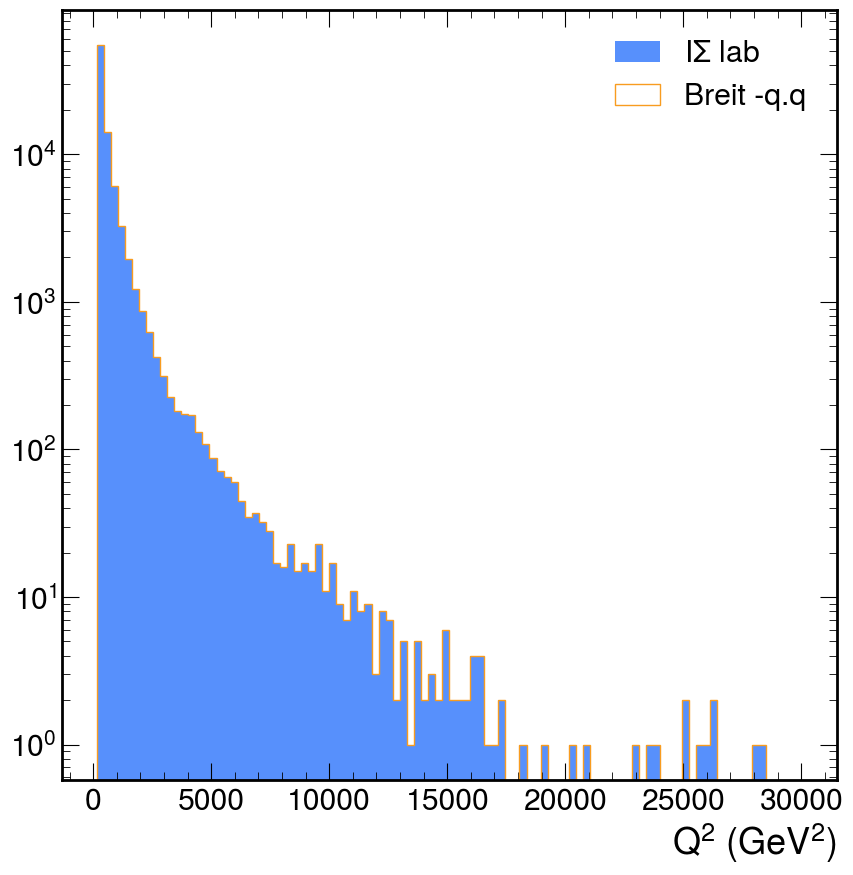

In [10]:
Q2_from_q_lab, ISigma_Q2_lab = calculate_Q2(kt_event_info)
Q2_from_q_breit, ISigma_Q2_breit = calculate_Q2(centauro_event_info)
plt.hist(Q2_from_q_lab, bins=100, range=(150, 30000), histtype="stepfilled", label="$I\Sigma~lab$")
plt.hist(Q2_from_q_breit, bins=100, range=(150, 30000), histtype="step", label="Breit -q.q")
plt.yscale('log')
plt.xlabel("$Q^2~(GeV^2)$")
plt.legend()

### Plotting jet observables using unfolded weights

In [11]:
# Gen level cuts. These are the same as the fiducial cuts from Vinny's dataloader
kt_gen_cuts = (filtered_kt["y"]>.2) & (filtered_kt["y"]<.7) & (filtered_kt["Q2"]>150)
centauro_gen_cuts = (filtered_centauro["y"]>.2) & (filtered_centauro["y"]<.7) & (filtered_centauro["Q2"]>150)

kt_weights = filtered_kt["weight"][kt_gen_cuts]*filtered_kt["unfolded_weights"][kt_gen_cuts]
centauro_weights = filtered_centauro["weight"][centauro_gen_cuts]*filtered_centauro["unfolded_weights"][centauro_gen_cuts]

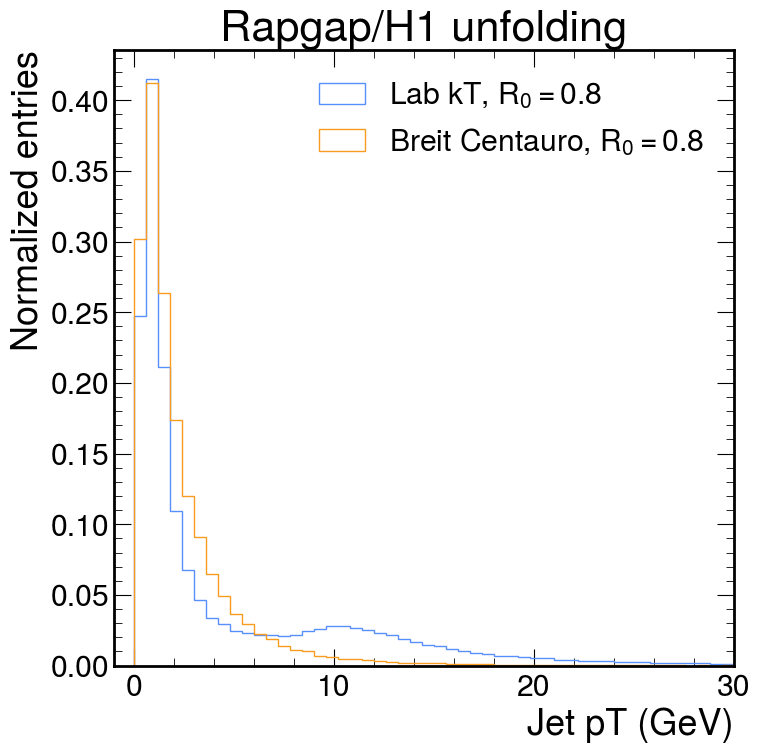

In [12]:
fig = plt.figure(figsize=(8,8))

# Applying the cuts to the jet observables, removing None entries, and making sure the weights have the same shape as the observable
masked_kt_jet_pT = filtered_kt["jet_pT"][kt_gen_cuts]
inner_shape = ak.num(masked_kt_jet_pT)
pT_kt_weights = np.repeat(kt_weights, inner_shape)
masked_kt_jet_pT = ak.flatten(masked_kt_jet_pT)
pT_kt_mask = ~ak.is_none(masked_kt_jet_pT)

masked_centauro_jet_pT = filtered_centauro["jet_pT"][centauro_gen_cuts]
inner_shape = ak.num(masked_centauro_jet_pT)
pT_centauro_weights = np.repeat(centauro_weights, inner_shape)
masked_centauro_jet_pT = ak.flatten(masked_centauro_jet_pT)
pT_centauro_mask = ~ak.is_none(masked_centauro_jet_pT)

plt.hist(
    masked_kt_jet_pT[pT_kt_mask],
    weights=pT_kt_weights[pT_kt_mask],
    bins=50,
    density=True,
    label=f"Lab kT, $R_0={R}$",
    range=(0,30),
    histtype='step'
)
plt.hist(
    masked_centauro_jet_pT[pT_centauro_mask],
    weights=pT_centauro_weights[pT_centauro_mask],
    bins=50,
    density=True,
    range=(0,30),
    label=f"Breit Centauro, $R_0={R}$",
    histtype='step'
)
plt.xlabel("Jet pT (GeV)")
plt.ylabel("Normalized entries")
plt.legend()
# plt.ylim(0,.1)
plt.xlim(-1,30)
plt.title(plot_title)
plt.savefig(f"../plots/Rapgap_{data_name}_unfolding_R{R}_jetpT.pdf")

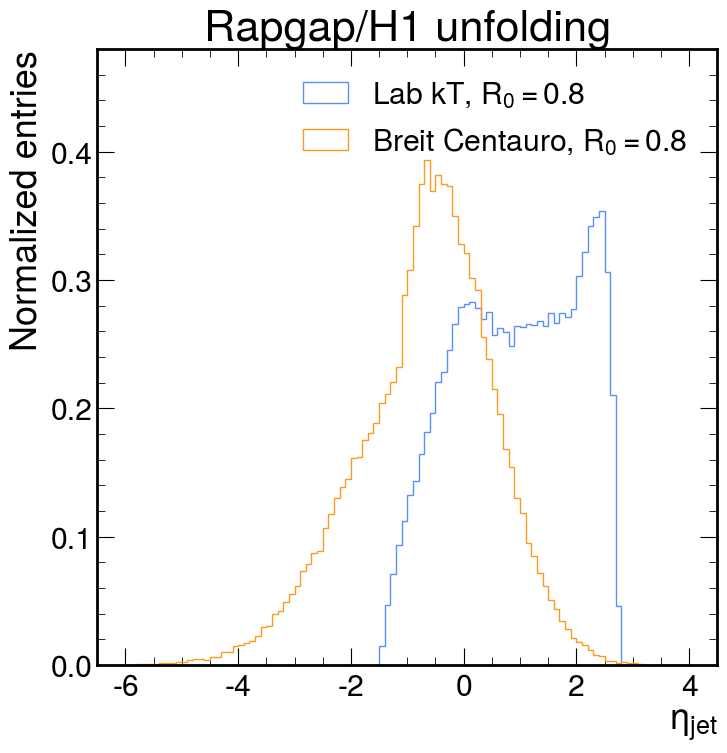

In [13]:
fig = plt.figure(figsize=(8,8))

masked_kt_jet_eta = filtered_kt["jet_eta"][kt_gen_cuts]
inner_shape = ak.num(masked_kt_jet_eta)
eta_kt_weights = np.repeat(kt_weights, inner_shape)
masked_kt_jet_eta = ak.flatten(masked_kt_jet_eta)
eta_kt_mask = ~ak.is_none(masked_kt_jet_eta)

masked_centauro_jet_eta = filtered_centauro["jet_eta"][centauro_gen_cuts]
inner_shape = ak.num(masked_centauro_jet_eta)
eta_centauro_weights = np.repeat(centauro_weights, inner_shape)
masked_centauro_jet_eta = ak.flatten(masked_centauro_jet_eta)
eta_centauro_mask = ~ak.is_none(masked_centauro_jet_eta)

plt.hist(
    masked_kt_jet_eta[eta_kt_mask],
    weights=eta_kt_weights[eta_kt_mask],
    bins=100,
    label=f"Lab kT, $R_0={R}$",
    density=True,
    range=(-6,4),
    histtype='step'
)
plt.hist(
    masked_centauro_jet_eta[eta_centauro_mask],
    weights=eta_centauro_weights[eta_centauro_mask],
    bins=100,
    label=f"Breit Centauro, $R_0={R}$",
    range=(-6,4),
    density=True,
    histtype='step'
)
plt.xlabel("$\eta_{jet}$")
plt.ylabel("Normalized entries")
plt.legend()
plt.ylim(0, 0.48)
plt.title(plot_title)
plt.savefig(f"../plots/Rapgap_{data_name}_unfolding_R{R}_jeteta.pdf")

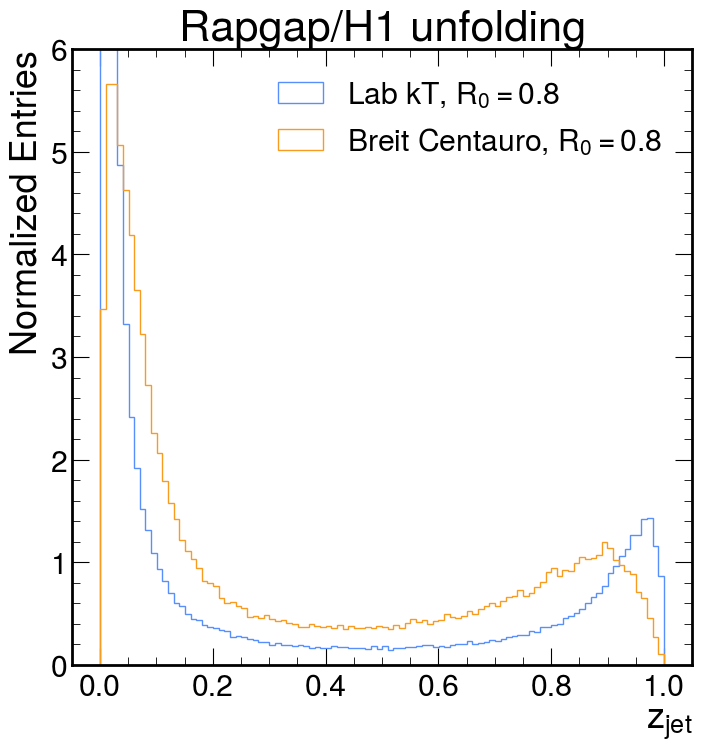

In [14]:
fig = plt.figure(figsize=(8,8))

masked_kt_jet_z = filtered_kt["z_jet"][kt_gen_cuts]
inner_shape = ak.num(masked_kt_jet_z)
z_kt_weights = np.repeat(kt_weights, inner_shape)
masked_kt_jet_z = ak.flatten(masked_kt_jet_z)
z_kt_mask = ~ak.is_none(masked_kt_jet_z)

masked_centauro_jet_z = filtered_centauro["z_jet"][centauro_gen_cuts]
inner_shape = ak.num(masked_centauro_jet_z)
z_centauro_weights = np.repeat(centauro_weights, inner_shape)
masked_centauro_jet_z = ak.flatten(masked_centauro_jet_z)
z_centauro_mask = ~ak.is_none(masked_centauro_jet_z)

kt_entries, kt_bins, _ = plt.hist(
    masked_kt_jet_z[z_kt_mask],
    weights=z_kt_weights[z_kt_mask],
    bins = 100,
    label=f"Lab kT, $R_0={R}$",
    histtype='step',
    density=True
)
centauro_entries, centauro_bins, _ = plt.hist(
    masked_centauro_jet_z[z_centauro_mask], 
    weights= z_centauro_weights[z_centauro_mask],
    bins = 100,
    label=f"Breit Centauro, $R_0={R}$",
    histtype='step',
    density=True
)
plt.xlabel("$z_{jet}$")
plt.ylabel("Normalized Entries")
plt.ylim(0,6)
# plt.xlim(0,2)
plt.legend()
plt.title(plot_title)
plt.savefig(f"../plots/Rapgap_{data_name}_unfolding_R{R}_zjet.pdf")

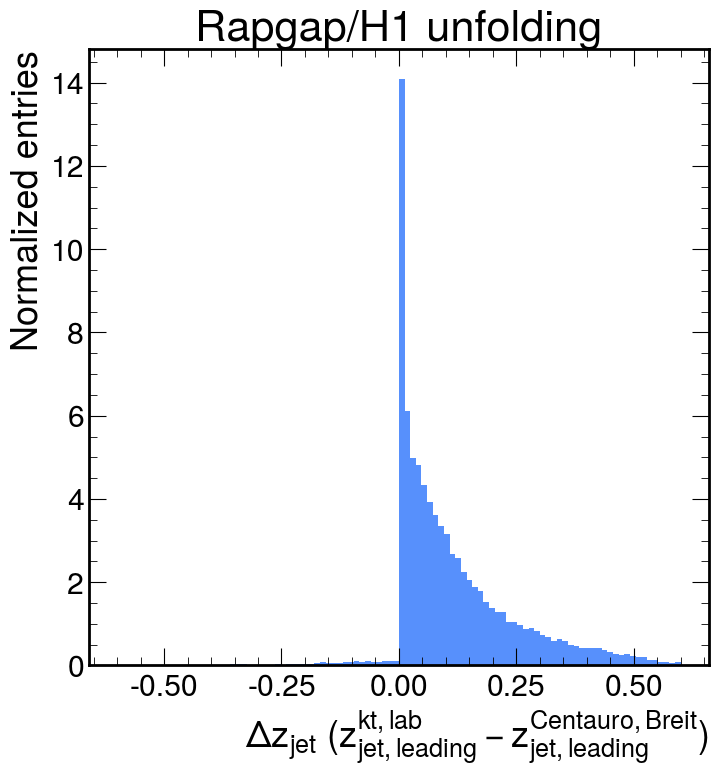

In [15]:
fig = plt.figure(figsize=(8,8))
plt.hist(
    delta_z,
    weights = centauro_event_info["weight"][:min_number_events][empty_jet_mask]*centauro_event_info["unfolded_weights"][:min_number_events][empty_jet_mask],
    bins=100, 
    range=(-.6,.6),
    density=True
)
plt.xlabel("$\Delta z_{jet}~(z_{jet, leading}^{kt, lab} - z_{jet, leading}^{Centauro, Breit})$")
plt.ylabel("Normalized entries")
plt.title(plot_title)
plt.savefig(f"../plots/Rapgap_{data_name}_unfolding_R{R}_Deltazjet.pdf")

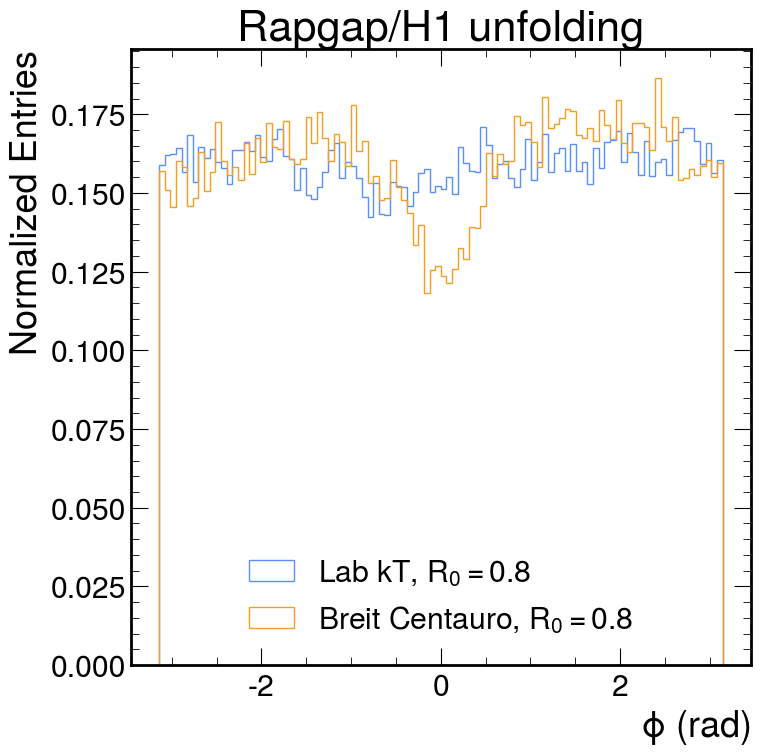

In [16]:
fig = plt.figure(figsize=(8,8))


masked_kt_jet_phi = filtered_kt["jet_phi"][kt_gen_cuts]
inner_shape = ak.num(masked_kt_jet_phi)
phi_kt_weights = np.repeat(kt_weights, inner_shape)
masked_kt_jet_phi = ak.flatten(masked_kt_jet_phi)
phi_kt_mask = ~ak.is_none(masked_kt_jet_phi)

masked_centauro_jet_phi = filtered_centauro["jet_phi"][centauro_gen_cuts]
inner_shape = ak.num(masked_centauro_jet_phi)
phi_centauro_weights = np.repeat(centauro_weights, inner_shape)
masked_centauro_jet_phi = ak.flatten(masked_centauro_jet_phi)
phi_centauro_mask = ~ak.is_none(masked_centauro_jet_phi)

masked_centauro_jet_phi = np.where(
    masked_centauro_jet_phi[phi_centauro_mask] > np.pi,
    masked_centauro_jet_phi[phi_centauro_mask] - 2 * np.pi,
    masked_centauro_jet_phi[phi_centauro_mask]
)
plt.hist(
    masked_kt_jet_phi[phi_kt_mask],
    weights = phi_kt_weights[phi_kt_mask], 
    label=f"Lab kT, $R_0={R}$",
    bins=100,
    density=True,
    histtype='step'
)
plt.hist(
    masked_centauro_jet_phi, 
    weights = phi_centauro_weights[phi_centauro_mask],
    label=f"Breit Centauro, $R_0={R}$",
    bins=100,
    density=True,
    histtype='step'
)

plt.xlabel("$\phi$ (rad)")
plt.ylabel("Normalized Entries")
plt.legend()
plt.title(plot_title)
plt.savefig(f"../plots/Rapgap_{data_name}_unfolding_R{R}_jetphi.pdf")

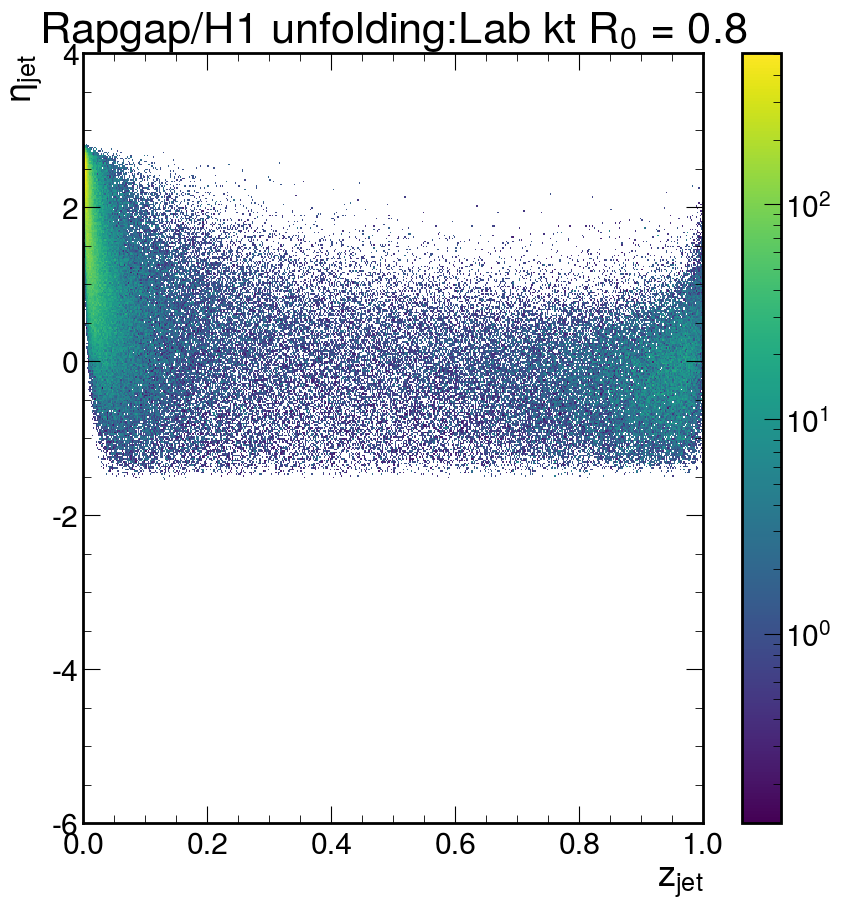

In [17]:
plt.hist2d(
    np.asarray(masked_kt_jet_z[z_kt_mask]),
    np.asarray(masked_kt_jet_eta[eta_kt_mask]),
    weights = np.asarray(eta_kt_weights[eta_kt_mask]),
    bins=(500,500), 
    range=[(0, 1.0), (-6,4)],
    norm = colors.LogNorm()
)
plt.xlabel("$z_{jet}$")
plt.ylabel("$\eta_{jet}$")
plt.colorbar()
plt.title(plot_title+f":Lab kt $R_0$ = {R}")
plt.savefig(f"../plots/Rapgap_{data_name}_unfolding_R{R}_Labkt_etazjet.pdf")

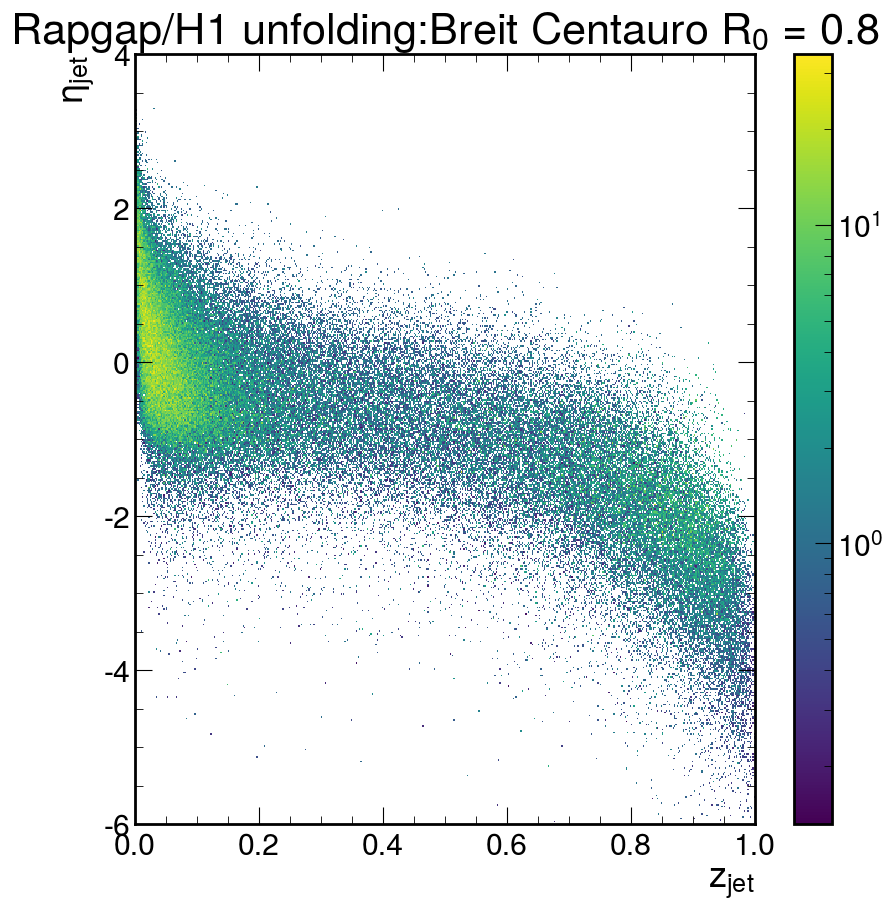

In [18]:
plt.hist2d(
    np.asarray(masked_centauro_jet_z[z_centauro_mask]),
    np.asarray(masked_centauro_jet_eta[eta_centauro_mask]),
    weights = np.asarray(eta_centauro_weights[eta_centauro_mask]),
    bins=(500,500),
    range=[(0, 1.0), (-6,4)],
    norm = colors.LogNorm()
)
plt.xlabel("$z_{jet}$")
plt.ylabel("$\eta_{jet}$")
plt.colorbar()
plt.title(plot_title+f":Breit Centauro $R_0$ = {R}")
plt.savefig(f"../plots/Rapgap_{data_name}_unfolding_R{R}_BreitCentauro_etazjet.pdf")